In [ ]:
'''Analyse (nach Schritt 4)
Untersuchung Infra: Welche Art der Infra kann ausgewertet werden?
- Welches Breitenspektrum
- Puffer
- Parken
- width
- 
'''

In [1]:
import json 
import pandas as pd
import geopandas as gpd
import os

import glob                             #verwendung von 'wildacards' in Dateinamen
from tqdm import tqdm                   #fuer Darstellen eines Fortschrittsbalkens
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.ticker import ScalarFormatter
import numpy as np

import pylab
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import anderson
from scipy.stats import jarque_bera
from datetime import date
from shapely import wkt

from datetime import date

datum=date.today().strftime("%y%m%d")

print('import finished')

import finished


In [2]:
path_OBS_OSM = '../OSM-OBS_klass'   #Ort an dem Klassifizierte gpkg-Datei (aus _1-3_Klassifizierung) liegt
path_OBS_OSM = path_OBS_OSM + '/*.gpkg'

#liest alle obs-Dateien ein und packt sie in eine liste. 
files_OBS_OSM = glob.glob(path_OBS_OSM)

read_file = max(files_OBS_OSM, key=os.path.getctime)
read_file

'../OSM-OBS_klass/OSM-OBS_Klass_240213.gpkg'

In [3]:
gdf_klass=gpd.read_file(max(files_OBS_OSM, key=os.path.getctime)) #klassifizierte und mit OSM gemergte OBS-Messwerte
gdf_klass['Radinfra'] = gdf_klass['Radinfra'].astype('string') #Datentyp String für Radinfra Spalte. Vorbereitung für das Auslesen.
gdf_klass.head()

/home/lukas/anaconda3/envs/MA-working/lib/python3.9/site-packages/geopandas/io/file.py:364: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  as_dt = pd.to_datetime(df[k], errors="ignore")


,distance_overtaker,distance_stationary,direction,way_id,course,speed,time,portal,osm_id,name,highway,ref,maxspeed,zone_traffic,lanes,lane_markings,lit,surface,bicycle,cycleway,cycleway_both,cycleway_left,cycleway_right,width,tracktype,smoothness,oneway,cycleway_lane,cycleway_both_lane,cycleway_right_lane,cycleway_left_lane,parking_lane_both,parking_lane_left,parking_lane_right,cycleway_separation_left,cycleway_separation_right,separation_left,separation_right,cycleway_bicycle,cycleway_both_bicycle,...,cycleway_both_marking_left,cycleway_both_marking_right,cycleway_both_traffic_sign,cycleway_both_marking_both,cycleway_right_buffer_right,cycleway_left_buffer_right,cycleway_both_buffer_right,cycleway_right_buffer_left,cycleway_left_buffer_left,cycleway_both_buffer_left,cycleway_right_buffer_both,cycleway_left_buffer_both,cycleway_both_buffer_both,cycleway_marking_both,cycleway_marking_left,cycleway_marking,cycleway_right_marking,cycleway_left_marking,cycleway_traffic_sign,parking_orientation,other_tags,geometry_y,Radinfra,Radwegbreite,PufferRechts,PufferLinks,GG-Radstreifen,GG-Radwegbreite,GG-PufferRechts,GG-PufferLinks,Fahrstreifenbreite,FSBundRad,Kernfahrbahn,Fahrbahn_Fliessverkehr,Ortslage,Geschwindigkeit_Numerisch,datetime_berlin,time_berlin,date_berlin,geometry
0,NaN,2.64,1,141561211,2.956398,3.083333,2022-08-11 09:38:31+00:00,adfc-brandenburg,141561211,Universitätsstraße,tertiary,None,50,None,2,no,yes,asphalt,None,None,lane,None,None,8,None,intermediate,None,None,advisory,None,None,None,None,None,None,None,None,None,None,None,...,dashed_line,None,none,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"""maxspeed:conditional""=>""30 @ (Mo-Fr 07:00-17:...","LINESTRING (14.3269026 51.7658807, 14.3268727 ...","1,Schutzstreifen,VZ:kein_VZ, linkeM_DL, rechte...",1.45,None,None,"Schutzstreifen,",1.45,None,None,2.55,4.0,5.1,8.0,inner,50,2022-08-11 09:38:31+00:00,11:38,11.08.2022,POINT (14.32561 51.76605)
1,1.67,1.70,1,141561211,2.895165,3.750000,2022-08-11 09:38:32+00:00,adfc-brandenburg,141561211,Universitätsstraße,tertiary,None,50,None,2,no,yes,asphalt,None,None,lane,None,None,8,None,intermediate,None,None,advisory,None,None,None,None,None,None,None,None,None,None,None,...,dashed_line,None,none,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"""maxspeed:conditional""=>""30 @ (Mo-Fr 07:00-17:...","LINESTRING (14.3269026 51.7658807, 14.3268727 ...","1,Schutzstreifen,VZ:kein_VZ, linkeM_DL, rechte...",1.45,None,None,"Schutzstreifen,",1.45,None,None,2.55,4.0,5.1,8.0,inner,50,2022-08-11 09:38:32+00:00,11:38,11.08.2022,POINT (14.32553 51.76606)
2,0.85,2.79,1,141561211,2.849412,4.055556,2022-08-11 09:38:34+00:00,adfc-brandenburg,141561211,Universitätsstraße,tertiary,None,50,None,2,no,yes,asphalt,None,None,lane,None,None,8,None,intermediate,None,None,advisory,None,None,None,None,None,None,None,None,None,None,None,...,dashed_line,None,none,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"""maxspeed:conditional""=>""30 @ (Mo-Fr 07:00-17:...","LINESTRING (14.3269026 51.7658807, 14.3268727 ...","1,Schutzstreifen,VZ:kein_VZ, linkeM_DL, rechte...",1.45,None,None,"Schutzstreifen,",1.45,None,None,2.55,4.0,5.1,8.0,inner,50,2022-08-11 09:38:34+00:00,11:38,11.08.2022,POINT (14.32541 51.76607)
3,1.26,NaN,1,141561211,2.900393,4.250000,2022-08-11 09:38:36+00:00,adfc-brandenburg,141561211,Universitätsstraße,tertiary,None,50,None,2,no,yes,asphalt,None,None,lane,None,None,8,None,intermediate,None,None,advisory,None,None,None,None,None,None,None,None,None,None,None,...,dashed_line,None,none,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"""maxspeed:conditional""=>""30 @ (Mo-Fr 07:00-17:...","LINESTRING (14.3269026 51.7658807, 14.3268727 ...","1,Schutzstreifen,VZ:kein_VZ, linkeM_DL, rechte...",1.45,None,None,"Schutzstreifen,",1.45,None,None,2.55,4.0,5.1,8.0,inner,50,2022-08-11 09:38:36+00:00,11:38,11.08.2022,POI

In [4]:
'''Plot Settings
'''

#Plotparameter
plt.rcParams["font.family"] = "Times New Roman"   #auf Schriftart TimesNewRoman setzen
plt.rcParams["legend.fontsize"] = 12              #schriftgröße Legende
plt.rcParams["legend.title_fontsize"] = 12        #schriftgröße Legendentitel
plt.rcParams["figure.titlesize"] = 12             #Schriftgröße Title (genutzt als Untertitel)
plt.rcParams["axes.labelsize"] = 12               #Größe von Achsbezeichung
plt.rcParams["xtick.labelsize"] = 10              #Größe von Achsbeschriftungen
plt.rcParams["ytick.labelsize"] = 10              #Größe von Achsbeschriftungen

cm_In = 1/2.54  #Umrechnungsfaktor cm in Inches
aufl = 300  #Auflösung in dpi.

#A4 hoch
plt_breite = 14 * cm_In
plt_hoehe = 8 * cm_In

#A3 Quer
#plt_breite = 42*cm_In   #16.53  #Inches
#plt_hoehe = 29.7*cm_In    #11.69

print("Plotbreite: " + str(round(plt_breite / cm_In, 2)) + "cm, " + str(round(plt_breite, 2)) + " Inch, " + "\nPlothöhe: " + str(round(plt_hoehe / cm_In, 2)) + "cm, " + str(round(plt_hoehe, 2)) + " Inch, ")

Plotbreite: 14.0cm, 5.51 Inch, 
Plothöhe: 8.0cm, 3.15 Inch, 


In [ ]:
#Plotten der unterschiedlichen Infrastrukturtypen
fig, ax = plt.subplots(figsize=(plt_breite, plt_hoehe/8*10.5), dpi = aufl, constrained_layout=True)
#erzeugen von gdf mit den Daten der zu zeigenden Infra
gdf_klass['Radinfra'] = gdf_klass['Radinfra'].astype('string')
gdf_RFS = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_SEI = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*Seitenstreifen)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_SSF = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*Schutzstreifen)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_UNB = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*,...streifen)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_PBL = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*PBL)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_BFS = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*Busfahrstr.)(?=.*Gesamtbrei)', regex=True) == True)].copy()
gdf_Misch = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*Misch)(?=.*Gesamtbrei)', regex=True) == True)].copy()
gdf_RFS_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('Radfahrstreifen', regex=True) == True)].copy()
gdf_SEI_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('Seitenstreifen', regex=True) == True)].copy()
gdf_SSF_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('Schutzstreifen', regex=True) == True)].copy()
gdf_UNB_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('...streifen', regex=False) == True)].copy()  #Regex False: Eingabe (punkte) werden nicht als regulärer Ausdruck interpretiert
gdf_PBL_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('PBL', regex=True) == True)].copy()
gdf_BFS_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('Busfahrstr.', regex=True) == True)].copy()
gdf_Misch_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('Misch', regex=True) == True)].copy()

#Datensätze ohne gemessenen Ü*berholabstand (links) löschen
gdf_RFS = gdf_RFS.dropna(subset=['distance_overtaker'])
gdf_SEI = gdf_SEI.dropna(subset=['distance_overtaker'])
gdf_SSF = gdf_SSF.dropna(subset=['distance_overtaker'])
gdf_UNB = gdf_UNB.dropna(subset=['distance_overtaker'])
gdf_PBL = gdf_PBL.dropna(subset=['distance_overtaker'])
gdf_BFS = gdf_BFS.dropna(subset=['distance_overtaker'])
gdf_Misch = gdf_Misch.dropna(subset=['distance_overtaker'])
gdf_RFS_all = gdf_RFS_all.dropna(subset=['distance_overtaker'])
gdf_SEI_all = gdf_SEI_all.dropna(subset=['distance_overtaker'])
gdf_SSF_all = gdf_SSF_all.dropna(subset=['distance_overtaker'])
gdf_UNB_all = gdf_UNB_all.dropna(subset=['distance_overtaker'])
gdf_PBL_all = gdf_PBL_all.dropna(subset=['distance_overtaker'])
gdf_BFS_all = gdf_BFS_all.dropna(subset=['distance_overtaker'])
gdf_Misch_all = gdf_Misch_all.dropna(subset=['distance_overtaker'])


#Breite von zwei Linienstärken einstellen
l_wide1=0.5
l_thin2=1
l_type1=':'
l_type2=':'
m_type1='.'
m_type2='o'
m_size1=2
m_size2=2
#Datens#tze zum Plot hinzufügen
plt.plot(gdf_SSF_all.groupby(gdf_SSF_all['distance_overtaker'].round(1))['distance_overtaker'].count(), "g", linewidth=l_thin2, linestyle=l_type2, marker=m_type2,  markersize=m_size2,  
         label = 'SSF, alle, n= '+gdf_SSF_all['distance_overtaker'].count().astype('str'))#Schutzstreifen (grün)
plt.plot(gdf_SSF.groupby(gdf_SSF['distance_overtaker'].round(1))['distance_overtaker'].count(), "g", linewidth=l_wide1, linestyle=l_type1, marker=m_type1,  markersize=m_size1,   
         label = 'SSF, +Breite, n= '+gdf_SSF['distance_overtaker'].count().astype('str')) #Schutzstreifen (grün)
plt.plot(gdf_RFS_all.groupby(gdf_RFS_all['distance_overtaker'].round(1))['distance_overtaker'].count(), 'tomato', linewidth=l_thin2, linestyle=l_type2, marker=m_type2,  markersize=m_size2,  
         label = 'RFS, alle, n= '+gdf_RFS_all['distance_overtaker'].count().astype('str'))#Radfahrstreifen (rot)
plt.plot(gdf_RFS.groupby(gdf_RFS['distance_overtaker'].round(1))['distance_overtaker'].count(), "r", linewidth=l_wide1, linestyle=l_type1, marker=m_type1,  markersize=m_size1,  
         label = 'RFS, +Breite, n= '+gdf_RFS['distance_overtaker'].count().astype('str'))       #Radfahrstreifen (rot)
'''plt.plot(gdf_SEI_all.groupby(gdf_SEI_all['distance_overtaker'].round(1))['distance_overtaker'].count(), 'lavender', linewidth=l_thin2, linestyle=l_type2, marker=m_type2,  markersize=m_size2,   
         label = 'SEI, alle, n= '+gdf_SEI_all['distance_overtaker'].count().astype('str'))#Radfahrstreifen (rot)
plt.plot(gdf_SEI.groupby(gdf_SEI['distance_overtaker'].round(1))['distance_overtaker'].count(), "m", linewidth=l_wide1, linestyle=l_type1, marker=m_type1,  markersize=m_size1,
         label = 'SEI, +Breite, n= '+gdf_SEI['distance_overtaker'].count().astype('str'))     #SSeitentreifen (grün)
plt.plot(gdf_UNB_all.groupby(gdf_UNB_all['distance_overtaker'].round(1))['distance_overtaker'].count(), "powderblue", linewidth=l_thin2, linestyle=l_type2, marker=m_type2,  markersize=m_size2,  
         label = 'UNB, alle, n= '+gdf_UNB_all['distance_overtaker'].count().astype('str'))       #Streifentyp unbekannt (blau)
plt.plot(gdf_UNB.groupby(gdf_UNB['distance_overtaker'].round(1))['distance_overtaker'].count(), linewidth=l_wide1, linestyle=l_type1, marker=m_type1,  markersize=m_size1, 
         label = 'UNB, +Breite, n= '+gdf_UNB['distance_overtaker'].count().astype('str'))
plt.plot(gdf_PBL_all.groupby(gdf_PBL_all['distance_overtaker'].round(1))['distance_overtaker'].count(), "y", linewidth=l_thin2, linestyle=l_type2, marker=m_type2,  markersize=m_size2,  
         label = 'PBL, alle, n= '+gdf_PBL_all['distance_overtaker'].count().astype('str'))       #Protected Bike Lane (grüngelb)
plt.plot(gdf_PBL.groupby(gdf_PBL['distance_overtaker'].round(1))['distance_overtaker'].count(), "y", linewidth=l_wide1, linestyle=l_type1, marker=m_type1,  markersize=m_size1,  
         label = 'PBL, +Breite, n= '+gdf_PBL['distance_overtaker'].count().astype('str'))       #Protected Bike Lane (grüngelb)
plt.plot(gdf_BFS_all.groupby(gdf_BFS_all['distance_overtaker'].round(1))['distance_overtaker'].count(), 'orange', linewidth=l_thin2, linestyle=l_type2, marker=m_type2,  markersize=m_size2,   
         label = 'BFS, alle, n= '+gdf_BFS_all['distance_overtaker'].count().astype('str'))   #Busfahrstreifen 
plt.plot(gdf_BFS.groupby(gdf_BFS['distance_overtaker'].round(1))['distance_overtaker'].count(), "orange", linewidth=l_wide1, linestyle=l_type1, marker=m_type1,  markersize=m_size1,   
         label = 'BFS, +Breite, n= '+gdf_BFS['distance_overtaker'].count().astype('str'))       #Busfahrstreifen 
'''
plt.plot(gdf_Misch_all.groupby(gdf_Misch_all['distance_overtaker'].round(1))['distance_overtaker'].count(), "black", linewidth=l_thin2, linestyle=l_type2, marker=m_type2,  markersize=m_size2,  
         label = 'Mischv., alle, n= '+gdf_Misch_all['distance_overtaker'].count().astype('str'))       #Streifentyp unbekannt (blau)
plt.plot(gdf_Misch.groupby(gdf_Misch['distance_overtaker'].round(1))['distance_overtaker'].count(), "black", linewidth=l_wide1, linestyle=l_type1, marker=m_type1,  markersize=m_size1,  
         label = 'Mischv., +Breite, n= '+gdf_Misch['distance_overtaker'].count().astype('str'))       #Streifentyp unbekannt (blau)

#Gitternetzlinien
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', axis = 'y', linewidth = 0.5)
ax.grid(which='minor', axis = 'y', linewidth = 0.3, linestyle='--')

plt.xlabel('Überholabstand [m]')
plt.ylabel('Anzahl Überholvorgänge')

loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

#Erzeugen der Legende und Hinzufügen Titel
spalten = 2
plt.legend()
#plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol = spalten) #Legende unterhalb der Grafik.
#plt.legend(bbox_to_anchor=(1, 1), loc="upper left") #Legende rechts neben der Grafik.



label_head = 'Anzahl von Messwerten nach\nInfrastrukturtyp und Überholabstand'
plt.title(label_head, fontsize=14)

MYDIR = ("../Ergebnisse/aa_Statistik/"+ read_file[-11:-5])
CHECK_FOLDER = os.path.isdir(MYDIR)
# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR) 

fig.savefig(MYDIR  + "/" + datum + "_Anzahl-Messwerte.png", dpi=aufl, bbox_inches="tight")  


In [126]:
gdf_Misch_all[gdf_Misch_all['distance_overtaker']!=0].groupby(['Ortslage']).count()
gdf_Misch_all.groupby(['Ortslage']).count()
#len(gdf_Misch_all)
#gdf_Misch_all.to_file("../OSM-OBS_klass/Untergruppen/OSM-OBS_Klass_gdf_Misch_all.gpkg", driver="GPKG")

,distance_overtaker,distance_stationary,direction,way_id,course,speed,time,portal,osm_id,name,highway,ref,maxspeed,zone_traffic,lanes,lane_markings,lit,surface,bicycle,cycleway,cycleway_both,cycleway_left,cycleway_right,width,tracktype,smoothness,oneway,cycleway_lane,cycleway_both_lane,cycleway_right_lane,cycleway_left_lane,parking_lane_both,parking_lane_left,parking_lane_right,cycleway_separation_left,cycleway_separation_right,separation_left,separation_right,cycleway_bicycle,cycleway_both_bicycle,...,cycleway_left_marking_both,cycleway_both_marking_left,cycleway_both_marking_right,cycleway_both_traffic_sign,cycleway_both_marking_both,cycleway_right_buffer_right,cycleway_left_buffer_right,cycleway_both_buffer_right,cycleway_right_buffer_left,cycleway_left_buffer_left,cycleway_both_buffer_left,cycleway_right_buffer_both,cycleway_left_buffer_both,cycleway_both_buffer_both,cycleway_marking_both,cycleway_marking_left,cycleway_marking,cycleway_right_marking,cycleway_left_marking,cycleway_traffic_sign,parking_orientation,other_tags,geometry_y,Radinfra,Radwegbreite,PufferRechts,PufferLinks,GG-Radstreifen,GG-Radwegbreite,GG-PufferRechts,GG-PufferLinks,Fahrstreifenbreite,FSBundRad,Kernfahrbahn,Fahrbahn_Fliessverkehr,Geschwindigkeit_Numerisch,datetime_berlin,time_berlin,date_berlin,geometry
Ortslage,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ausser,2470,470,2470,2470,2470,2470,2470,2470,2470,817,2470,1958,2458,15,1581,76,460,2433,80,137,1958,15,56,22,0,1241,22,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1215,2470,2470,0,0,0,1,0,0,0,4,4,22,22,2458,2470,2470,2470,2470
inner,9958,4150,9958,9958,9958,9942,9958,9958,9958,9880,9958,3388,9948,230,6814,2206,6993,8945,1721,610,4430,1252,1313,501,2,5062,1507,0,0,22,137,565,278,237,1,0,0,0,21,7,...,0,0,0,4,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,4,0,9577,9958,9958,32,4,0,212,5,4,0,715,715,894,902,9948,9958,9958,9958,9958
unbekannt,1589,619,1589,1589,1589,1579,1589,1589,1589,852,1589,314,0,0,414,125,465,982,52,25,186,4,66,37,38,283,121,0,0,0,1,4,4,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1096,1589,1589,0,0,0,1,0,0,0,2,2,37,37,0,1589,1589,1589,1589


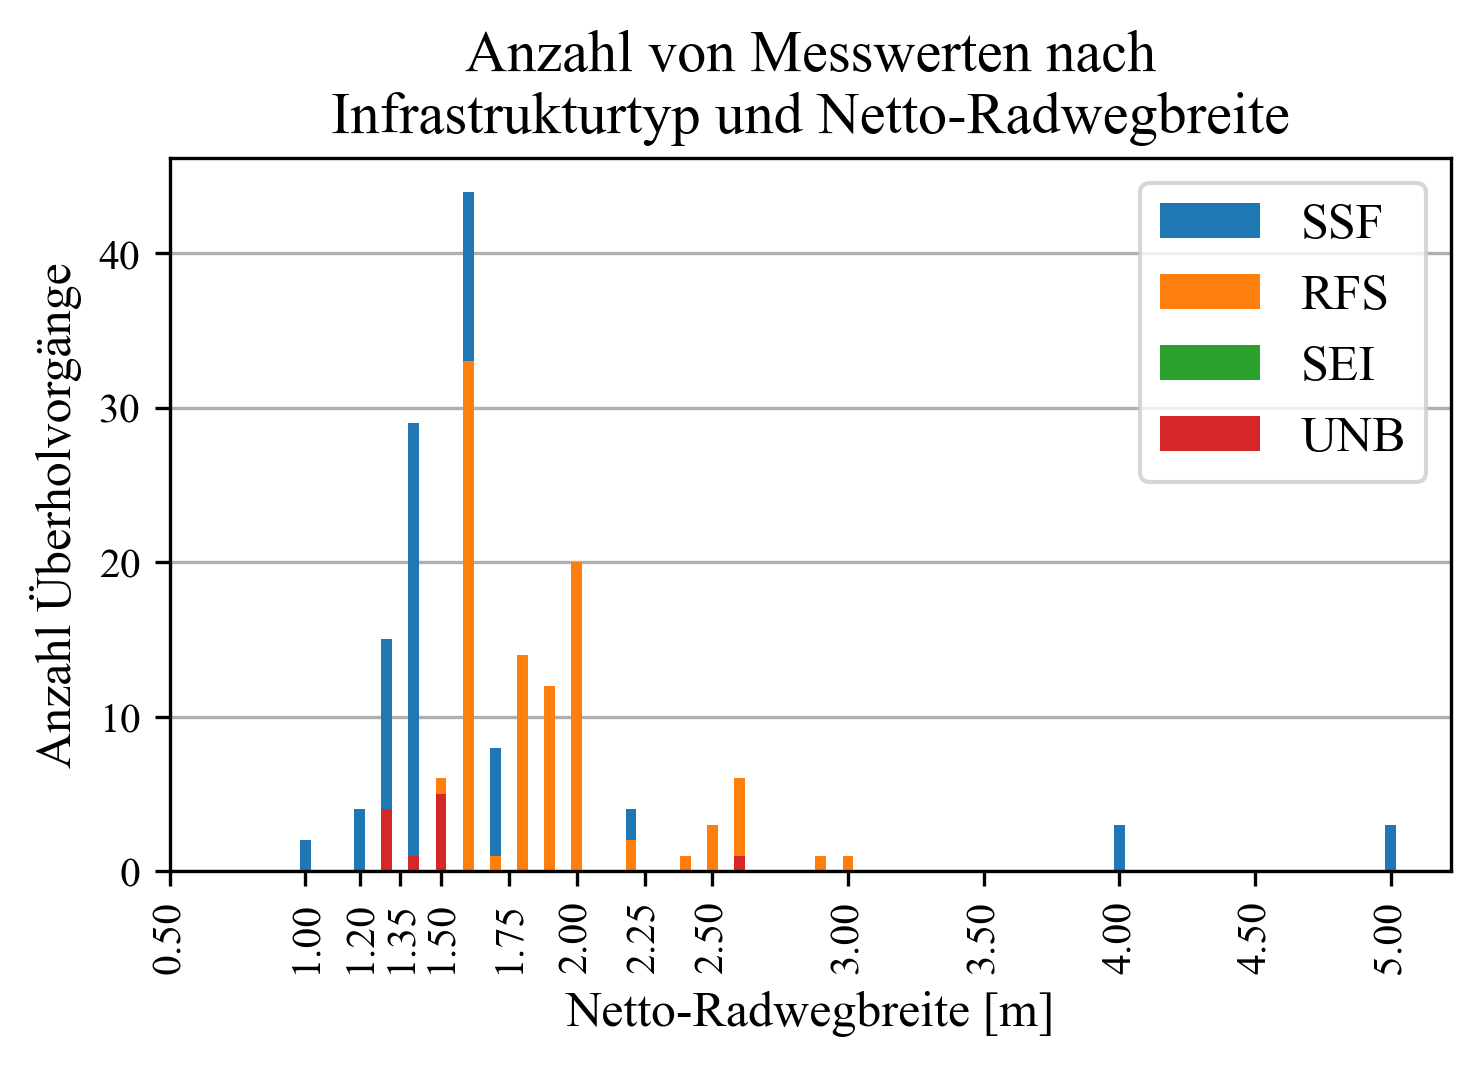

In [127]:
fig, ax = plt.subplots(figsize=(plt_breite, plt_hoehe), dpi = aufl)

#alle vorkommenden Werte für X-Skala extrahieren (Welche Radwegebreiten gibt es?)
breiten = pd.unique(gdf_klass['Radwegbreite'])
breiten = np.sort(breiten[~np.isnan(breiten)])

#Breiten über bestimmtem Wert aussortieren.
'''for i in range(0, len(breiten)):
    if breiten[i] > 3:
        breiten=breiten[:i]
        break

#Erstellen der Bins: Werte jeweils mittig zwischen vorkommenden Radwegebreiten
skala[0] = breiten[0]-((breiten[1]-breiten[0])/2)
for i in range(0, len(breiten)-1):
    skala[i+1] = breiten[i]+((breiten[i+1]-breiten[i])/2)
skala[len(breiten)] = breiten[len(breiten)-1]+(breiten[len(breiten)-1]-breiten[len(breiten)-2])/2'''

skala = [0]*(len(breiten)*2)
#Erstellen von Mini-Bins: Werte jeweils +-2cm größer als vorhandene Messwerte
n=0
for i in range(0, len(breiten)):
    skala[n] = breiten[i]-0.02
    n=n+1
    skala[n] = breiten[i]+0.02
    n=n+1

#Daten als Histogramm, Unterteilung der Messwerte nach den oben ermittelten Werten
plt.hist(gdf_SSF['Radwegbreite'], bins=skala, label="SSF") 
plt.hist(gdf_RFS['Radwegbreite'], bins=skala, label="RFS")
plt.hist(gdf_SEI['Radwegbreite'], bins=skala, label="SEI")
plt.hist(gdf_UNB['Radwegbreite'], bins=skala, label="UNB")
#plt.hist(gdf_Misch['Radwegbreite'], bins=skala, label="Misch")


#Beschriftung X-Achse vorgeben
bereich = [0.5, 1.0, 1.20, 1.35, 1.5, 1.75, 2.0, 2.25, 2.5, 3, 3.5, 4, 4.5, 5]
#bereich_txt = [str(round(i,2)) for i in bereich] #wird gar nicht (mehr) verwendet...
ax.set_xticks(bereich)
ax.tick_params(axis='x', labelrotation=90)

#Beschriftung und Grid Y-Achse
'''Für normale Skala: dann aber kleine Werte nicht mehr sichtbar'''
#ax.set_yticks([0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700],[0,'',200,'',400,'',600,'',800,'',1000,'',1200,'',1400,'',1600,''])
'''Für logarithmische Skala: schreibt in nicht wissenschaftlichem Format'''
#ax.yaxis.set_major_formatter(ScalarFormatter())


ax.set_axisbelow(True)
ax.grid(axis='y')

#Achsbezeichnung
plt.legend()
plt.xlabel('Netto-Radwegbreite [m]')
plt.ylabel('Anzahl Überholvorgänge')

#Ueberschrift
label_head = 'Anzahl von Messwerten nach\nInfrastrukturtyp und Netto-Radwegbreite'
plt.title(label_head, fontsize=14)

fig.savefig(MYDIR  + "/" + datum + "_Anzahl-Messwerte_nach-Radwegbreite.png", dpi=300, bbox_inches="tight")  

/home/lukas/anaconda3/envs/MA-working/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6826: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/lukas/anaconda3/envs/MA-working/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6827: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


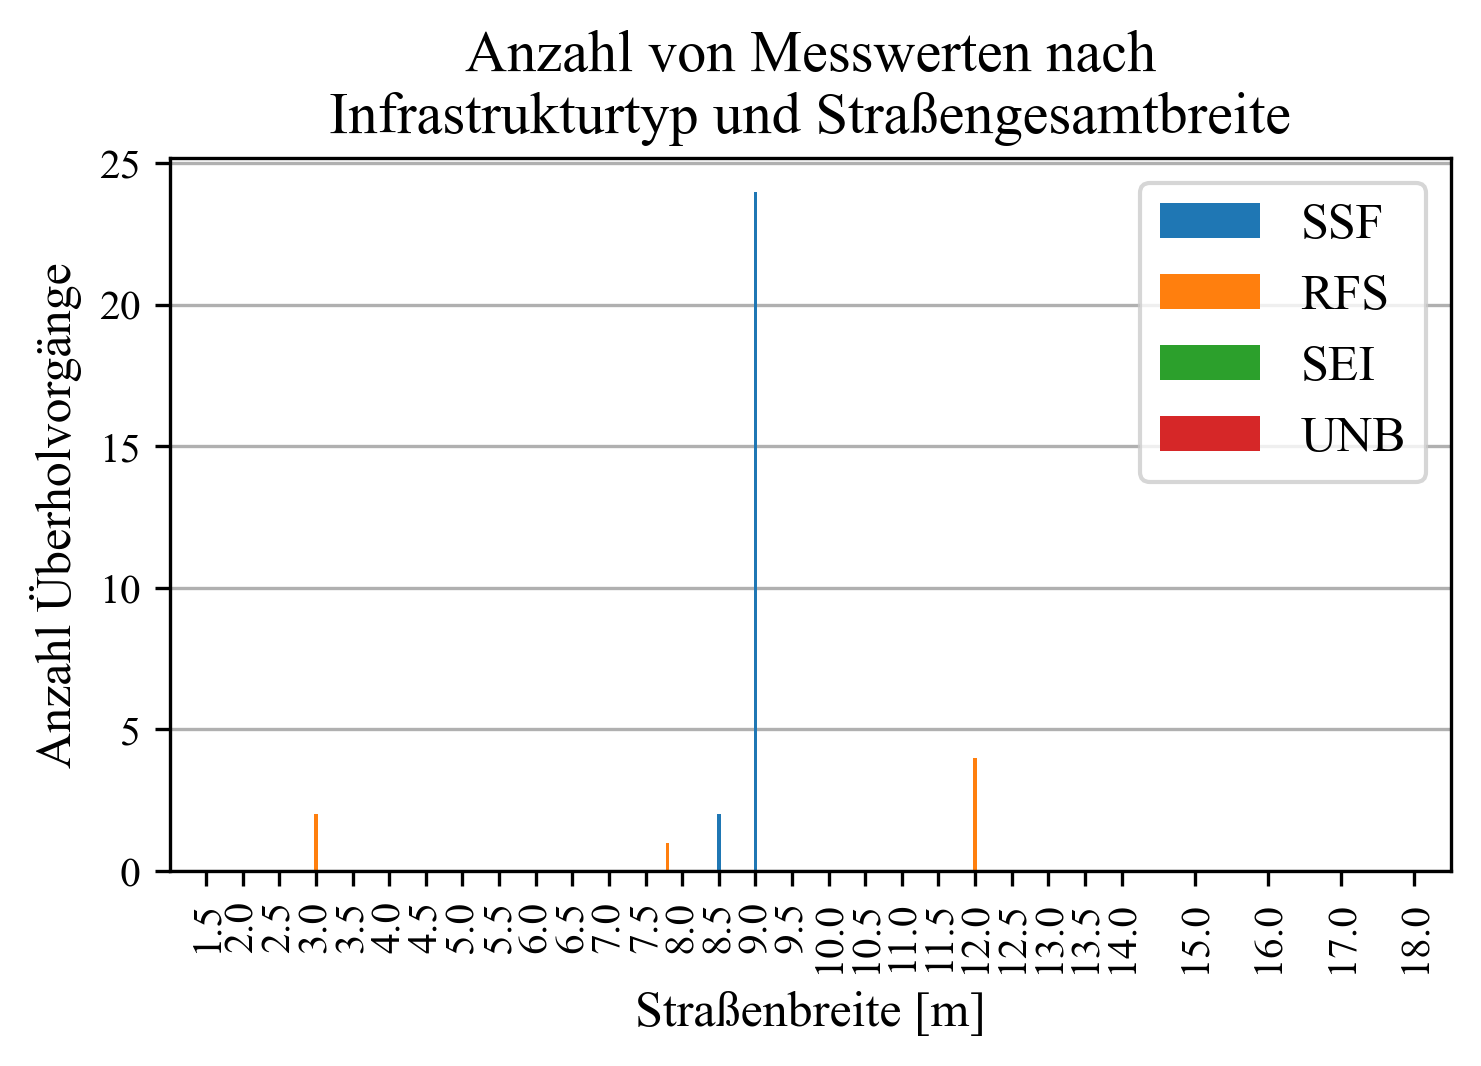

In [128]:
fig, ax = plt.subplots(figsize=(plt_breite, plt_hoehe), dpi = aufl)

#alle vorkommenden Werte für X-Skala extrahieren (Welche Radwegebreiten gibt es?)
breiten_ges = pd.unique(pd.to_numeric(gdf_klass['width']))
breiten_ges = np.sort(breiten_ges[~np.isnan(breiten_ges)])

#Breiten über bestimmtem Wert aussortieren.
'''for i in range(0, len(breiten)):
    if breiten[i] > 3:
        breiten=breiten[:i]
        break

#Erstellen der Bins: Werte jeweils mittig zwischen vorkommenden Radwegebreiten
skala[0] = breiten[0]-((breiten[1]-breiten[0])/2)
for i in range(0, len(breiten)-1):
    skala[i+1] = breiten[i]+((breiten[i+1]-breiten[i])/2)
skala[len(breiten)] = breiten[len(breiten)-1]+(breiten[len(breiten)-1]-breiten[len(breiten)-2])/2'''

skala_ges = [0]*(len(breiten_ges)*2)
#Erstellen von Mini-Bins: Werte jeweils +-2cm größer als vorhandene Messwerte
n=0
for i in range(0, len(breiten_ges)):
    skala_ges[n] = breiten_ges[i]-0.024
    n=n+1
    skala_ges[n] = breiten_ges[i]+0.024
    n=n+1

#Daten als Histogramm, Unterteilung der Messwerte nach den oben ermittelten Werten
plt.hist(pd.to_numeric(gdf_SSF['width']), bins=skala_ges, label="SSF") 
plt.hist(pd.to_numeric(gdf_RFS['width']), bins=skala_ges, label="RFS")
plt.hist(pd.to_numeric(gdf_SEI['width']), bins=skala_ges, label="SEI")
plt.hist(pd.to_numeric(gdf_UNB['width']), bins=skala_ges, label="UNB")

#Beschriftung X-Achse vorgeben
bereich_ges = [1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,15.0,16.0,17.0,18.0]
#bereich_txt = [str(round(i,2)) for i in bereich] #wird gar nicht (mehr) verwendet...
ax.set_xticks(bereich_ges)
plt.xlim((1, 18.5))
ax.tick_params(axis='x', labelrotation=90)

#Beschriftung und Grid Y-Achse
'''Für normale Skala: dann aber kleine Werte nicht mehr sichtbar'''
#ax.set_yticks([0,100,200,300,400,500,600,700,800,900,1000,1100],[0,'',200,'',400,'',600,'',800,'',1000,''])
'''Für logarithmische Skala: schreibt in nicht wissenschaftlichem Format'''
#ax.yaxis.set_major_formatter(ScalarFormatter())


ax.set_axisbelow(True)
ax.grid(axis='y')

#Achsbezeichnung
plt.legend()
plt.xlabel('Straßenbreite [m]')
plt.ylabel('Anzahl Überholvorgänge')

#Ueberschrift
label_head = 'Anzahl von Messwerten nach\nInfrastrukturtyp und Straßengesamtbreite'
plt.title(label_head, fontsize=14)

fig.savefig(MYDIR  + "/" + datum + "_Anzahl-Messwerte_nach-Straßenbreite.png", dpi=300, bbox_inches="tight")  

In [129]:
#breiten_ges
#gdf_klass['Radwegbreite']
pd.to_numeric(gdf_klass['width'])
#gdf_klass['width']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
19706   NaN
19707   NaN
19708   NaN
19709   NaN
19710   NaN
Name: width, Length: 19711, dtype: float64

In [130]:
breiten_ges
#skala_ges

array([ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.3,  5.5,  6. ,  6.5,
        6.7,  7. ,  7.1,  7.3,  7.7,  7.8,  7.9,  8. ,  8.5,  9. ,  9.9,
       10. , 10.9, 11. , 11.1, 11.3, 11.4, 11.5, 11.7, 12. , 12.3, 12.4,
       12.8, 12.9, 14.1, 14.3, 14.6, 14.7, 15. , 15.5, 15.8])

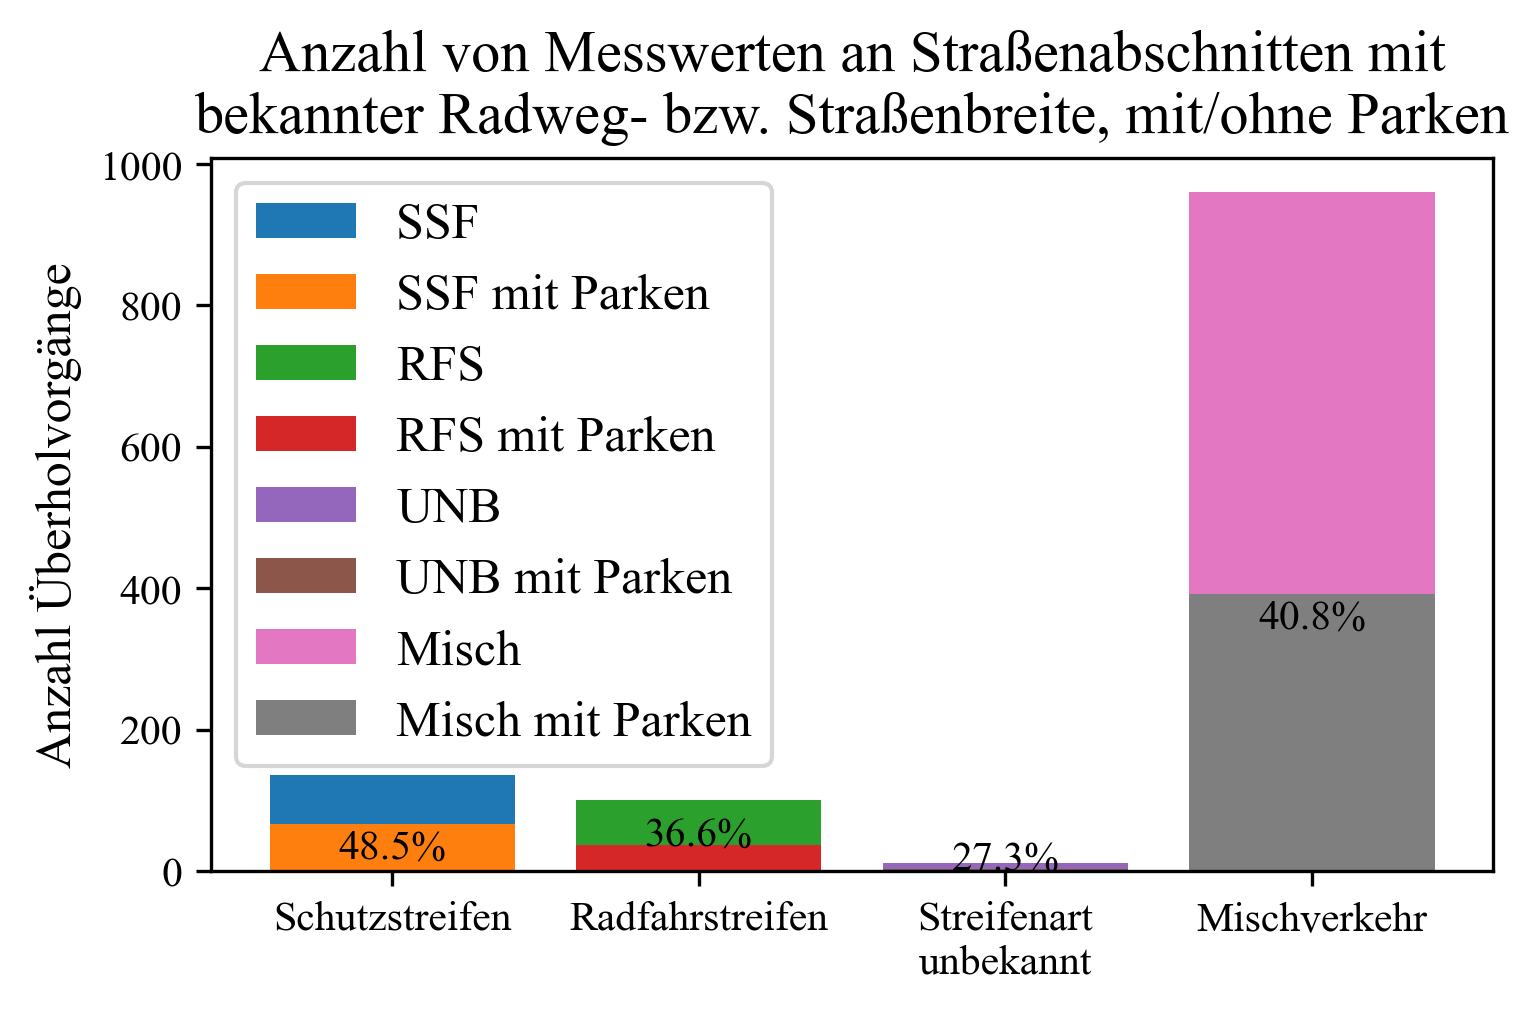

In [131]:
fig, ax = plt.subplots(figsize=(plt_breite, plt_hoehe), dpi = aufl)

#Balken für Diagramm erstellen
plt.bar("Schutzstreifen", gdf_SSF.count(), label="SSF ")
plt.bar("Schutzstreifen", gdf_SSF[(gdf_SSF['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="SSF mit Parken")
plt.bar("Radfahrstreifen", gdf_RFS.count(), label="RFS")
plt.bar("Radfahrstreifen", gdf_RFS[(gdf_RFS['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="RFS mit Parken")
#plt.bar("Seitenstreifen", gdf_SEI.count(), label="SEI")
#plt.bar("Seitenstreifen", gdf_SEI[(gdf_SEI['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="SEI mit Parken")
plt.bar("Streifenart\nunbekannt", gdf_UNB.count(), label="UNB")
plt.bar("Streifenart\nunbekannt", gdf_UNB[(gdf_UNB['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="UNB mit Parken")
plt.bar("Mischverkehr", gdf_Misch.count(), label="Misch")
plt.bar("Mischverkehr", gdf_Misch[(gdf_Misch['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="Misch mit Parken")

#Referenzwert zur Platzierung der Prozentzahl. Sollte größter Wert sein, da sich danach die Y-Skala berechnet 
#Texthöhe ~ 5% des höchsten Skalenwerts
#Mischverkehr vsl. Wert mit meisten Einträgen, bestimmt also die Höhe der Skale
ref_val = 0.05 * len(gdf_Misch) 

#Beschriftung Anteil mit Parken
ges_SSF = gdf_SSF['Radinfra'].count()
park_SSF = (gdf_SSF['Radinfra'][(gdf_SSF['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_SSF = str(round(park_SSF/ges_SSF*100,1))+'%'
#Darstellung der Prozentzahl vor dem Balken, zu dem es gehört (dem kleinere), wenn es rein passt. Ansonsten knapp darüber.
if park_SSF > ref_val:  
    below = ref_val
else:
    below = 0
plt.annotate(prozent_SSF, ("Schutzstreifen", park_SSF-below), ha='center')

ges_RFS = gdf_RFS['Radinfra'].count()
park_RFS = (gdf_RFS['Radinfra'][(gdf_RFS['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_RFS = str(round(park_RFS/ges_RFS*100,1))+'%'
if park_RFS > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_RFS, ("Radfahrstreifen", park_RFS-below), ha='center')

'''ges_SEI = gdf_SEI['Radinfra'].count()
park_SEI = (gdf_SEI['Radinfra'][(gdf_SEI['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_SEI = str(round(park_SEI/ges_SEI*100,1))+'%'
if park_SEI > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_SEI, ("Seitenstreifen", park_SEI-below), ha='center')'''

ges_UNB = gdf_UNB['Radinfra'].count()
park_UNB = (gdf_UNB['Radinfra'][(gdf_UNB['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_UNB = str(round(park_UNB/ges_UNB*100,1))+'%'
if park_UNB > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_UNB, ("Streifenart\nunbekannt", park_UNB-below), ha='center')

ges_Misch = gdf_Misch['Radinfra'].count()
park_Misch = (gdf_Misch['Radinfra'][(gdf_Misch['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_Misch = str(round(park_Misch/ges_Misch*100,1))+'%'
if park_SSF > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_Misch, ("Mischverkehr", park_Misch-below), ha='center')

#Achsbezeichnung
plt.legend()
#plt.xlabel('Infrastrukturtyp')
plt.ylabel('Anzahl Überholvorgänge')

#Ueberschrift
label_head = 'Anzahl von Messwerten an Straßenabschnitten mit\nbekannter Radweg- bzw. Straßenbreite, mit/ohne Parken'
plt.title(label_head, fontsize=14)

fig.savefig(MYDIR  + "/" + datum + "_Anzahl-Messwerte_Parken.png", dpi=300, bbox_inches="tight")  

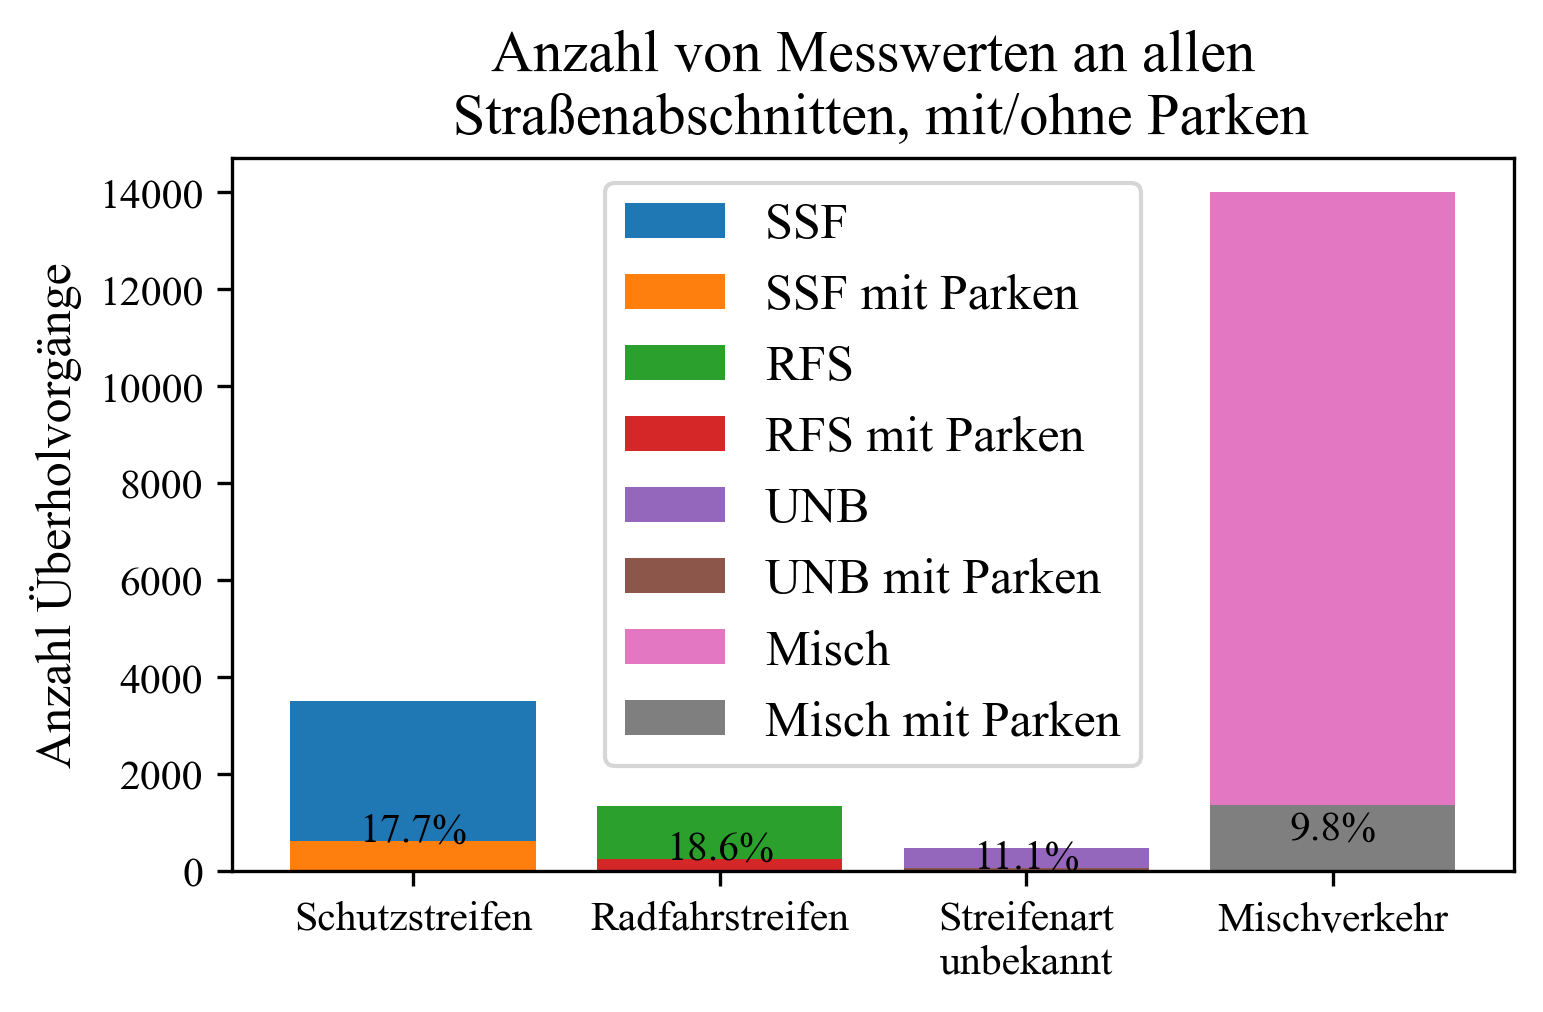

In [132]:
fig, ax = plt.subplots(figsize=(plt_breite, plt_hoehe), dpi = aufl)

#Balken für Diagramm erstellen
plt.bar("Schutzstreifen", gdf_SSF_all.count(), label="SSF ")
plt.bar("Schutzstreifen", gdf_SSF_all[(gdf_SSF_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="SSF mit Parken")
plt.bar("Radfahrstreifen", gdf_RFS_all.count(), label="RFS")
plt.bar("Radfahrstreifen", gdf_RFS_all[(gdf_RFS_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="RFS mit Parken")
#plt.bar("Seitenstreifen", gdf_SEI.count(), label="SEI")
#plt.bar("Seitenstreifen", gdf_SEI[(gdf_SEI['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="SEI mit Parken")
plt.bar("Streifenart\nunbekannt", gdf_UNB_all.count(), label="UNB")
plt.bar("Streifenart\nunbekannt", gdf_UNB_all[(gdf_UNB_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="UNB mit Parken")
plt.bar("Mischverkehr", gdf_Misch_all.count(), label="Misch")
plt.bar("Mischverkehr", gdf_Misch_all[(gdf_Misch_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="Misch mit Parken")


ref_val = 0.05 * len(gdf_Misch_all) #Mischverkehr vsl. Wert mit meisten Einträgen, bestimmt also die Höhe der Skale. Texthöhe ~ 5% des höchsten Skalenwerts


#Beschriftung Anteil mit Parken
ges_SSF_all = gdf_SSF_all['Radinfra'].count()
park_SSF_all = (gdf_SSF_all['Radinfra'][(gdf_SSF_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_SSF_all = str(round(park_SSF_all/ges_SSF_all*100,1))+'%'
if park_SSF_all > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_SSF_all, ("Schutzstreifen", park_SSF_all-below), ha='center')

ges_RFS_all = gdf_RFS_all['Radinfra'].count()
park_RFS_all = (gdf_RFS_all['Radinfra'][(gdf_RFS_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_RFS_all = str(round(park_RFS_all/ges_RFS_all*100,1))+'%'
if park_RFS_all > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_RFS_all, ("Radfahrstreifen", park_RFS_all-below), ha='center')

'''ges_SEI = gdf_SEI['Radinfra'].count()
park_SEI = (gdf_SEI['Radinfra'][(gdf_SEI['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_SEI = str(round(park_SEI/ges_SEI*100,1))+'%'
if park_SEI > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_SEI, ("Seitenstreifen", park_SEI-below), ha='center')'''

ges_UNB_all = gdf_UNB_all['Radinfra'].count()
park_UNB_all = (gdf_UNB_all['Radinfra'][(gdf_UNB_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_UNB_all = str(round(park_UNB_all/ges_UNB_all*100,1))+'%'
if park_UNB_all > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_UNB_all, ("Streifenart\nunbekannt", park_UNB_all-below), ha='center')

ges_Misch_all = gdf_Misch_all['Radinfra'].count()
park_Misch_all = (gdf_Misch_all['Radinfra'][(gdf_Misch_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
prozent_Misch_all = str(round(park_Misch_all/ges_Misch_all*100,1))+'%'
if park_Misch_all > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_Misch_all, ("Mischverkehr", park_Misch_all-below), ha='center')

#Achsbezeichnung
plt.legend()
#plt.xlabel('Infrastrukturtyp')
plt.ylabel('Anzahl Überholvorgänge')

#Ueberschrift
label_head = 'Anzahl von Messwerten an allen\n Straßenabschnitten, mit/ohne Parken'
plt.title(label_head, fontsize=14)

fig.savefig(MYDIR  + "/" + datum + "_Anzahl-Messwerte_Parken-ges.png", dpi=300, bbox_inches="tight")  

/tmp/ipykernel_4147/2854123159.py:41: RuntimeWarning: invalid value encountered in long_scalars
  prozent_puffer_SEI = str(round(puffer_SEI/park_SEI*100,1))+'%'


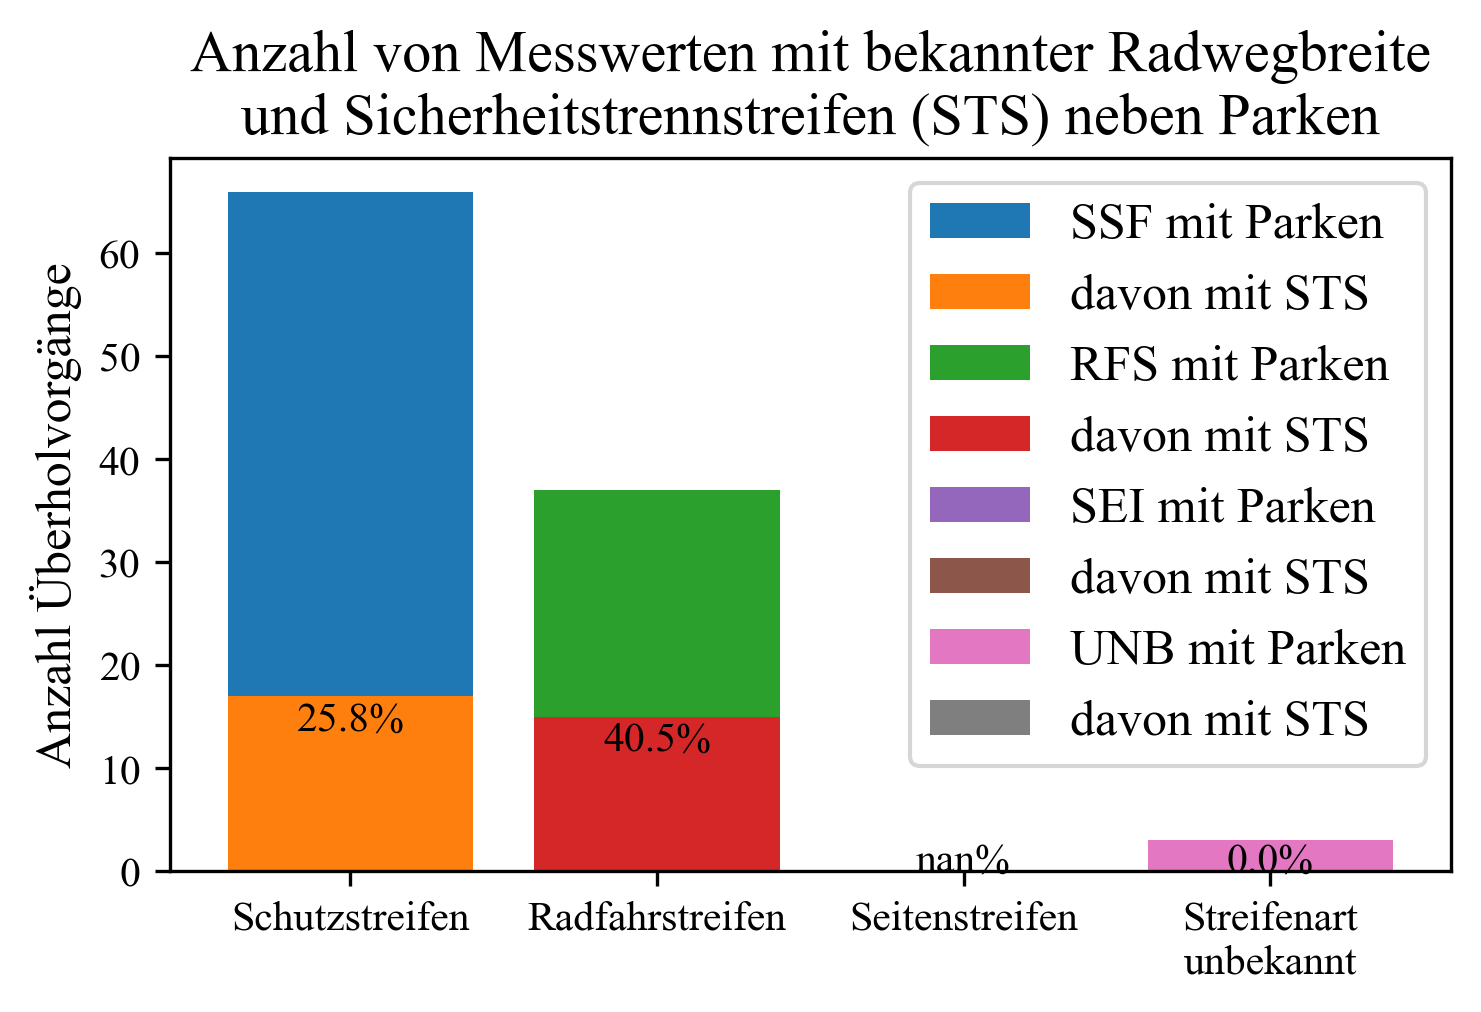

In [133]:
fig, ax = plt.subplots(figsize=(plt_breite, plt_hoehe), dpi = aufl)

#Balken für Diagramm erstellen

plt.bar("Schutzstreifen", gdf_SSF[(gdf_SSF['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="SSF mit Parken")
plt.bar("Schutzstreifen", gdf_SSF[(gdf_SSF['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit STS")

plt.bar("Radfahrstreifen", gdf_RFS[(gdf_RFS['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="RFS mit Parken")
plt.bar("Radfahrstreifen", gdf_RFS[(gdf_RFS['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit STS")

plt.bar("Seitenstreifen", gdf_SEI[(gdf_SEI['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="SEI mit Parken")
plt.bar("Seitenstreifen", gdf_SEI[(gdf_SEI['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit STS")

plt.bar("Streifenart\nunbekannt", gdf_UNB[(gdf_UNB['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="UNB mit Parken")
plt.bar("Streifenart\nunbekannt", gdf_UNB[(gdf_UNB['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit STS")

ref_val = 0.05 * gdf_SSF['Radinfra'][(gdf_SSF['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count() #Schutzsstreifen vsl. Wert mit meisten Einträgen, bestimmt also die Höhe der Skale. Texthöhe ~ 5% des höchsten Skalenwerts


#Beschriftung Anteil mit Parken
park_SSF = (gdf_SSF['Radinfra'][(gdf_SSF['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
puffer_SSF = (gdf_SSF['Radinfra'][(gdf_SSF['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count())
prozent_puffer_SSF = str(round(puffer_SSF/park_SSF*100,1))+'%'
if puffer_SSF > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_puffer_SSF, ("Schutzstreifen", puffer_SSF-below), ha='center')

park_RFS = (gdf_RFS['Radinfra'][(gdf_RFS['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
puffer_RFS = (gdf_RFS['Radinfra'][(gdf_RFS['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count())
prozent_puffer_RFS = str(round(puffer_RFS/park_RFS*100,1))+'%'
if puffer_RFS > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_puffer_RFS, ("Radfahrstreifen", puffer_RFS-below), ha='center')

park_SEI = (gdf_SEI['Radinfra'][(gdf_SEI['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
puffer_SEI = (gdf_SEI['Radinfra'][(gdf_SEI['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count())
prozent_puffer_SEI = str(round(puffer_SEI/park_SEI*100,1))+'%'
if puffer_SEI > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_puffer_SEI, ("Seitenstreifen", puffer_SEI-below), ha='center')

park_UNB = (gdf_UNB['Radinfra'][(gdf_UNB['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
puffer_UNB = (gdf_UNB['Radinfra'][(gdf_UNB['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count())
prozent_puffer_UNB = str(round(puffer_UNB/park_UNB*100,1))+'%'
if puffer_UNB > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_puffer_UNB, ("Streifenart\nunbekannt", puffer_UNB-below), ha='center')


#Achsbezeichnung
plt.legend()
#plt.xlabel('Infrastrukturtyp')
plt.ylabel('Anzahl Überholvorgänge')

#Ueberschrift
label_head = 'Anzahl von Messwerten mit bekannter Radwegbreite\nund Sicherheitstrennstreifen (STS) neben Parken'
plt.title(label_head, fontsize=14)

fig.savefig(MYDIR  + "/" + datum + "_Anzahl-Messwerte_Parken-mit-Sicherheitstrennstreifen_RW-Breite.png", dpi=300, bbox_inches="tight")  

/tmp/ipykernel_4147/1924080052.py:41: RuntimeWarning: invalid value encountered in long_scalars
  prozent_puffer_SEI = str(round(puffer_SEI/park_SEI*100,1))+'%'


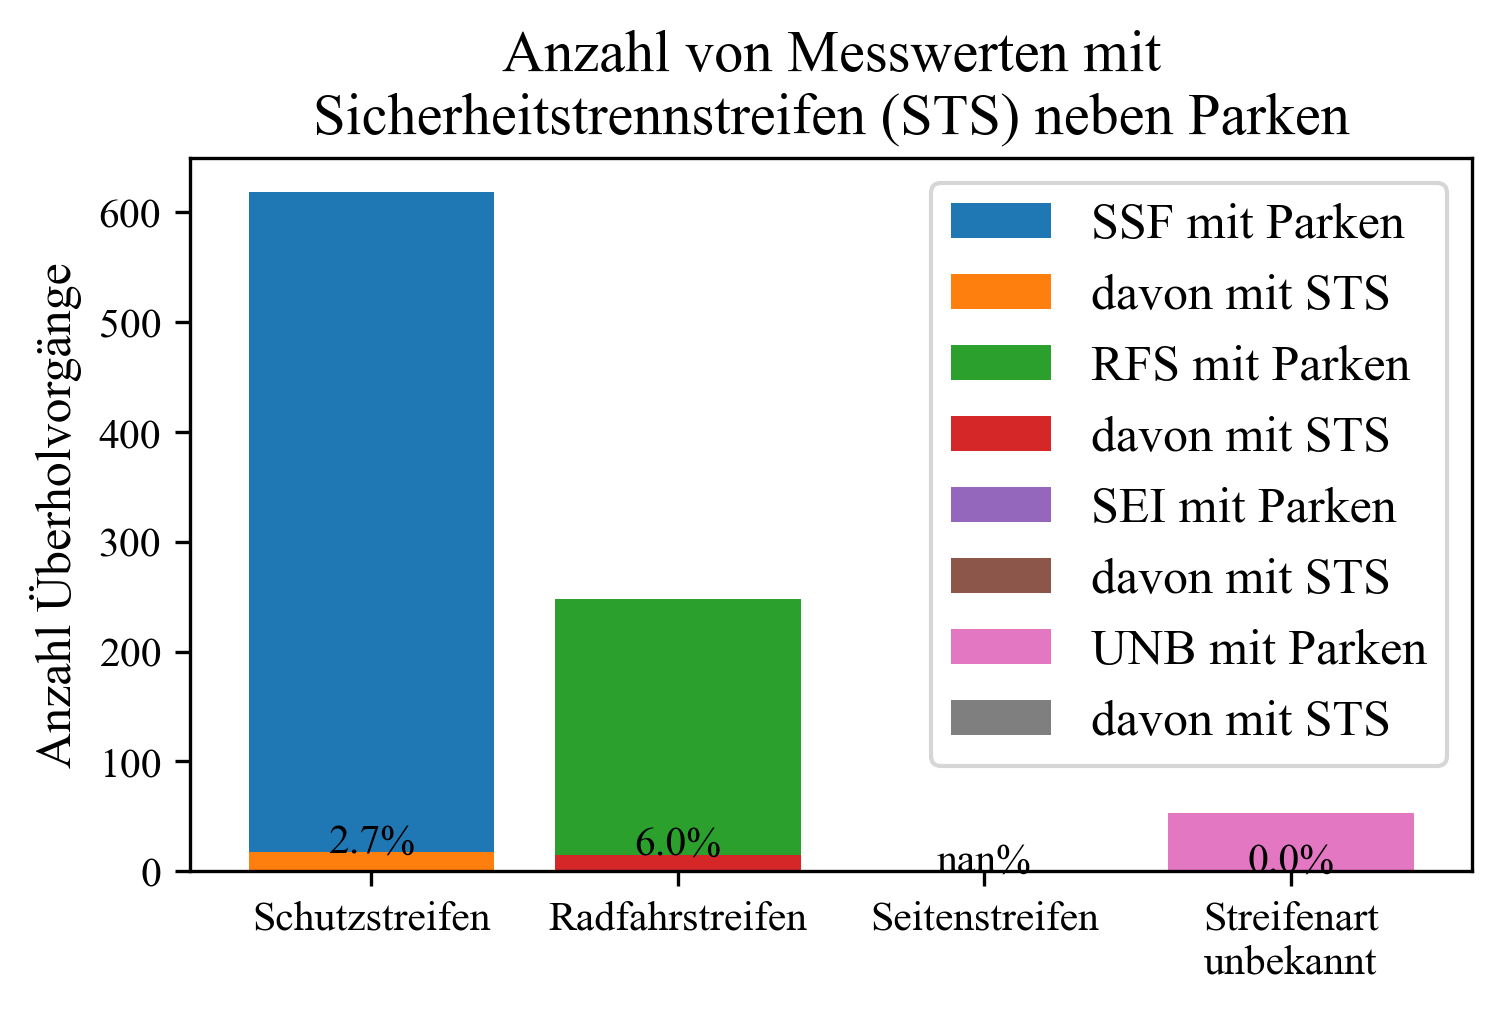

In [134]:
fig, ax = plt.subplots(figsize=(plt_breite, plt_hoehe), dpi = aufl)

#Balken für Diagramm erstellen

plt.bar("Schutzstreifen", gdf_SSF_all[(gdf_SSF_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="SSF mit Parken")
plt.bar("Schutzstreifen", gdf_SSF_all[(gdf_SSF_all['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit STS")

plt.bar("Radfahrstreifen", gdf_RFS_all[(gdf_RFS_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="RFS mit Parken")
plt.bar("Radfahrstreifen", gdf_RFS_all[(gdf_RFS_all['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit STS")

plt.bar("Seitenstreifen", gdf_SEI_all[(gdf_SEI_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="SEI mit Parken")
plt.bar("Seitenstreifen", gdf_SEI_all[(gdf_SEI_all['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit STS")

plt.bar("Streifenart\nunbekannt", gdf_UNB_all[(gdf_UNB_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count(), label="UNB mit Parken")
plt.bar("Streifenart\nunbekannt", gdf_UNB_all[(gdf_UNB_all['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit STS")

ref_val = 0.05 * gdf_SSF_all['Radinfra'][(gdf_SSF_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count() #Schutzsstreifen vsl. Wert mit meisten Einträgen, bestimmt also die Höhe der Skale. Texthöhe ~ 5% des höchsten Skalenwerts


#Beschriftung Anteil mit Parken
park_SSF = (gdf_SSF_all['Radinfra'][(gdf_SSF_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
puffer_SSF = (gdf_SSF_all['Radinfra'][(gdf_SSF_all['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count())
prozent_puffer_SSF = str(round(puffer_SSF/park_SSF*100,1))+'%'
if puffer_SSF > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_puffer_SSF, ("Schutzstreifen", puffer_SSF-below), ha='center')

park_RFS = (gdf_RFS_all['Radinfra'][(gdf_RFS_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
puffer_RFS = (gdf_RFS_all['Radinfra'][(gdf_RFS_all['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count())
prozent_puffer_RFS = str(round(puffer_RFS/park_RFS*100,1))+'%'
if puffer_RFS > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_puffer_RFS, ("Radfahrstreifen", puffer_RFS-below), ha='center')

park_SEI = (gdf_SEI_all['Radinfra'][(gdf_SEI_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
puffer_SEI = (gdf_SEI_all['Radinfra'][(gdf_SEI_all['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count())
prozent_puffer_SEI = str(round(puffer_SEI/park_SEI*100,1))+'%'
if puffer_SEI > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_puffer_SEI, ("Seitenstreifen", puffer_SEI-below), ha='center')

park_UNB = (gdf_UNB_all['Radinfra'][(gdf_UNB_all['Radinfra'].str.contains(r'^(?=.*park*)', regex=True))].count())
puffer_UNB = (gdf_UNB_all['Radinfra'][(gdf_UNB_all['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count())
prozent_puffer_UNB = str(round(puffer_UNB/park_UNB*100,1))+'%'
if puffer_UNB > ref_val:
    below = ref_val
else:
    below = 0
plt.annotate(prozent_puffer_UNB, ("Streifenart\nunbekannt", puffer_UNB-below), ha='center')


#Achsbezeichnung
plt.legend()
#plt.xlabel('Infrastrukturtyp')
plt.ylabel('Anzahl Überholvorgänge')

#Ueberschrift
label_head = 'Anzahl von Messwerten mit\nSicherheitstrennstreifen (STS) neben Parken'
plt.title(label_head, fontsize=14)

fig.savefig(MYDIR  + "/" + datum + "_Anzahl-Messwerte_Parken-mit-Sicherheitstrennstreifen_gesamt.png", dpi=300, bbox_inches="tight")  

In [ ]:
'''Auswertung: 
- Anz. Rechte Messwerte, davon mit Parken
- Anz. Rechte Messwerte, davon Parken = No
- Anz. Parken, davon mit rechten Messwerten'''


KeyError: '2'

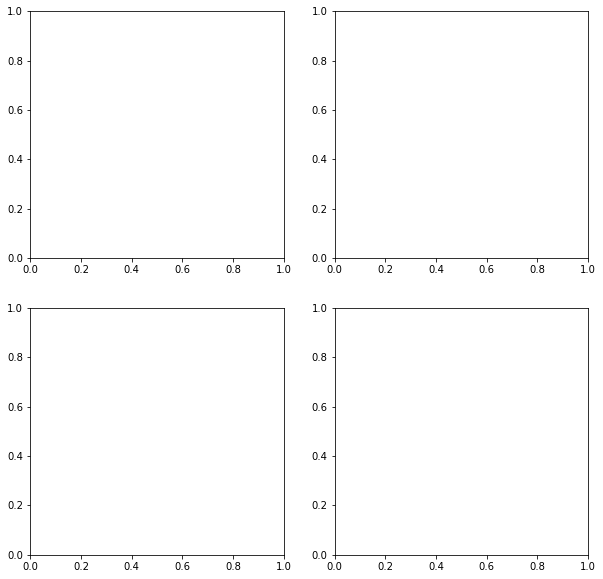

In [8]:
#Pufferbreiten Links und REchts für SSF und RFS

fig, ax = plt.subplots(2,2, figsize=(plt_breite, plt_hoehe), dpi = aufl)

#Balken für Diagramm erstellen

colors={'No':'red', 
        'no':'red',
        'None':'tomato',
        'none':'tomato',
        'Yes':'gray',
        'yes':'gray',
        '0.5':'wheat',
        '0.50':'wheat',
        '0.55':'orange',
        '0.6':'gold',
        '0.60':'gold',
        '0.7':'yellow',
        '0.70':'yellow',
        '0.75':'lime',
        '0.8':'forestgreen',
        '0.80':'forestgreen',
        '1':'aqua',
        '1.4':'royalblue',
        '3':'violet'}

'''optional: Pufferbreiten als Labels
labels=sorted(pd.unique(gdf_SSF['PufferLinks'].dropna()))  '''

ax[0,0].pie(gdf_SSF.sort_values(['PufferRechts']).groupby(gdf_SSF['PufferRechts'])['Radinfra'].count(), labels=gdf_SSF.sort_values(['PufferRechts']).groupby(gdf_SSF['PufferRechts'])['Radinfra'].count(), autopct='%1.1f%%', colors=[colors[v] for v in gdf_SSF.sort_values(['PufferRechts']).groupby(gdf_SSF['PufferRechts'])['Radinfra'].count().keys()])
ax[0,1].pie(gdf_SSF.sort_values(['PufferLinks']).groupby(gdf_SSF['PufferLinks'])['Radinfra'].count(), labels=gdf_SSF.sort_values(['PufferLinks']).groupby(gdf_SSF['PufferLinks'])['Radinfra'].count(), autopct='%1.1f%%', colors=[colors[v] for v in gdf_SSF.sort_values(['PufferLinks']).groupby(gdf_SSF['PufferLinks'])['Radinfra'].count().keys()])

ax[1,0].pie(gdf_RFS.sort_values(['PufferRechts']).groupby(gdf_RFS['PufferRechts'])['Radinfra'].count(), labels=gdf_RFS.sort_values(['PufferRechts']).groupby(gdf_RFS['PufferRechts'])['Radinfra'].count(), autopct='%1.1f%%', colors=[colors[v] for v in gdf_RFS.sort_values(['PufferRechts']).groupby(gdf_RFS['PufferRechts'])['Radinfra'].count().keys()])
ax[1,1].pie(gdf_RFS.sort_values(['PufferLinks']).groupby(gdf_RFS['PufferLinks'])['Radinfra'].count(), labels=gdf_RFS.sort_values(['PufferLinks']).groupby(gdf_RFS['PufferLinks'])['Radinfra'].count(), autopct='%1.1f%%', colors=[colors[v] for v in gdf_RFS.sort_values(['PufferLinks']).groupby(gdf_RFS['PufferLinks'])['Radinfra'].count().keys()])

#plt.pie("Schutzstreifen", gdf_SSF[(gdf_SSF['Radinfra'].str.contains(r'^(?=.*park*)(?=.*uffer*)(?!.*linkerPuffer.*|.*rechterPuffer.no.*).*', regex=True))].count(), label="davon mit Sicherheitstrennstreifen")

#Beschriftung Anteil mit Parken



#Achsbezeichnung
#plt.legend()
#plt.xlabel('Infrastrukturtyp')
#plt.ylabel('Anzahl Überholvorgänge')

#Ueberschrift
#label_head = 'Anzahl von Messwerten mit\nSicherheitstrennstreifen neben Parken'
#plt.title(label_head)
#plt.setp(autotexts, size='x-small')

'''Idee für Legende: Manuell die Color-Liste durchgehen. Zwei Listen erstellen mit Farbe und Breite. Sind zwei Farben gleich, nur die erste Beschriftung merken.
Dann irgendwie wieder die richtigen Farben den Farbnamen zuordnen (wie in Ploterzeugung gemacht?)'''
pie_slices = []
pie_labels = []
  
for ax in fig.axes:
    Slice, Label = ax.get_legend_handles_labels()
    # print(Label)
    pie_slices.extend(Slice)
    pie_labels.extend(Label)
  
fig.legend(pie_slices, pie_labels, loc='upper right')
plt.show()

In [390]:
labels=(pd.unique(gdf_SSF['PufferRechts'].dropna()))
sorted(labels)

['0.5', '0.55', '0.6', '0.7', 'no', 'none', 'yes']

In [384]:
pd.unique(gdf_SSF['PufferRechts'])

array(['no', nan, '0.6', 'yes', '0.5', 'none', '0.7', '0.55'],
      dtype=object)

In [400]:
gdf_SSF.sort_values(['PufferRechts']).groupby(gdf_SSF['PufferRechts'])['Radinfra'].count()

PufferRechts
0.5      16
0.55     21
0.6     126
0.7       2
no       27
none     39
yes       4
Name: Radinfra, dtype: int64

In [389]:
gdf_SSF.groupby(gdf_SSF['PufferRechts'])['Radinfra'].count()

PufferRechts
0.5      16
0.55     21
0.6     126
0.7       2
no       27
none     39
yes       4
Name: Radinfra, dtype: int64